In [1]:
#load watermark extension
%load_ext watermark
#print watermark for notebook
%watermark

2018-04-24T22:25:54

CPython 2.7.14
IPython 5.4.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [2]:
#https://ipyton.org/ipython-docdex/config/extsions/autoreload.html
%reload_ext autoreload
%autoreload 2

#version information
%reload_ext version_information
%version_information Cython, matplotlib, numpy, pandas,  qutip, seaborn, scipy, sklearn, tqdm, version_information,


Software,Version
Python,2.7.14 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython,5.4.1
OS,Darwin 17.3.0 x86_64 i386 64bit
Cython,0.26.1
matplotlib,2.1.0
numpy,1.13.3
pandas,0.20.3
qutip,The 'qutip' distribution was not found and is required by the application
seaborn,0.8.0
scipy,0.19.1


In [3]:
#standard packages
import pandas as pd
import numpy as np
#package for loop load time bar
from tqdm import tqdm
#statistical and machine learning packages
import scipy as sp
from sklearn.preprocessing import OneHotEncoder

#import scoring for machine learning
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score, auc,precision_recall_curve,classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm



#imports for preparing data for sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn. preprocessing import LabelEncoder

# packages for plotting 
import matplotlib.pyplot as plt
import seaborn as sns
#command to have graphs display in notebook
%matplotlib inline

In [4]:
#loading user order information
instacart_file=pd.read_csv('/Users/luca/anaconda2/Springboard/Capstone Project 1/Data/orders.csv')
df_orders=pd.DataFrame(instacart_file,)
df_orders.head(5)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
df_orders.nunique()

order_id                  3421083
user_id                    206209
eval_set                        3
order_number                  100
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64

In [6]:
#capture the last order information for each user
g = df_orders.groupby('user_id')
data_p1=g.last()
data_p1['order_from_last']=1

In [7]:
#capture the second to last order information for each user
data_p2=g.nth(-2)
data_p2['order_from_last']=2

In [8]:
#capture the third to last order information for each user
data_p3=g.nth(-3)
data_p3['order_from_last']=3

In [9]:
#capture the fourth to last order information for each user
data_p4=g.nth(-4)
data_p4['order_from_last']=4

In [10]:
#capture the third to last order information for each user
data_p3=data_p3.reset_index()
#sample 150 customers to make predictions for 
np.random.seed(42)
#reduce data size 
small=data_p3.sample(1000)

In [11]:
#data frame to ensure we have the same users in the test set
sample=pd.DataFrame(small['user_id'])

In [12]:
#save data to pass to SVD notebook to run single vector model on this trian set
data_svd = sample
%store data_svd
#del data # This has deleted the variable

Stored 'data_svd' (DataFrame)


In [13]:
#loading product reorder information
instacart_file2=pd.read_csv('/Users/luca/anaconda2/Springboard/Capstone Project 1/Data/order_products__prior.csv')
df_prod_orders=pd.DataFrame(instacart_file2,)
df_prod_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [14]:
#loading information for product names
instacart_products=pd.read_csv('/Users/luca/anaconda2/Springboard/Capstone Project 1/Data/products.csv')
df_prod=pd.DataFrame(instacart_products,)
df_prod.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [15]:
#add reorder information to training data
df_train=pd.merge(df_prod_orders,data_p3, how= 'inner',left_on="order_id", right_on='order_id')
df_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last
0,7,34050,1,0,142903,30.0,prior,2,14,11,3
1,7,46802,2,0,142903,30.0,prior,2,14,11,3
2,16,9755,1,1,174840,13.0,prior,3,12,18,3
3,16,25466,2,0,174840,13.0,prior,3,12,18,3
4,16,45437,3,0,174840,13.0,prior,3,12,18,3


In [16]:
#since we have train and test data broken apart by user previous order we can ensure we test only the users we trained for
small_train=pd.merge(df_train,sample, how= 'inner',left_on="user_id", right_on='user_id')
small_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last
0,11188,39928,1,1,46510,30.0,prior,3,12,5,3
1,11188,46969,2,1,46510,30.0,prior,3,12,5,3
2,11188,37646,3,1,46510,30.0,prior,3,12,5,3
3,11188,13176,4,1,46510,30.0,prior,3,12,5,3
4,11188,44430,5,0,46510,30.0,prior,3,12,5,3


In [17]:
#check to make sure NaN is taken care of 
small_train.isnull().any()

order_id                  False
product_id                False
add_to_cart_order         False
reordered                 False
user_id                   False
days_since_prior_order    False
eval_set                  False
order_dow                 False
order_hour_of_day         False
order_number              False
order_from_last           False
dtype: bool

In [18]:
#see how many products and users we have 
small_train.nunique()

order_id                  1000
product_id                4686
add_to_cart_order           48
reordered                    2
user_id                   1000
days_since_prior_order      31
eval_set                     1
order_dow                    7
order_hour_of_day           23
order_number                79
order_from_last              1
dtype: int64

In [19]:
#capture the second to last order information for each user as a test set
data_p2=g.nth(-2)
data_p2['order_from_last']=2
data_p2=data_p2.reset_index()

#for test set add in reorder information
df_test=pd.merge(df_prod_orders,data_p2, how= 'inner',left_on="order_id", right_on='order_id')

#since we have train and test data broken apart by user previous order we can ensure we test only the users we trained for
small_test=pd.merge(df_test,sample, how= 'inner',left_on="user_id", right_on='user_id')
small_test.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last
0,5753,6041,1,0,124653,29.0,prior,6,11,3,2
1,5753,37483,2,0,124653,29.0,prior,6,11,3,2
2,5753,46359,3,0,124653,29.0,prior,6,11,3,2
3,5753,11837,4,0,124653,29.0,prior,6,11,3,2
4,5753,44987,5,0,124653,29.0,prior,6,11,3,2


In [20]:
sample.nunique()

user_id    1000
dtype: int64

In [21]:

small_test.nunique()

order_id                  1000
product_id                4700
add_to_cart_order           48
reordered                    2
user_id                   1000
days_since_prior_order      31
eval_set                     1
order_dow                    7
order_hour_of_day           23
order_number                79
order_from_last              1
dtype: int64

In [22]:
small_test.shape

(9875, 11)

In [23]:
small_train.shape

(9874, 11)

## Now we prep the feature columns to be in an appropriate format to utilize sklearn api 

In [24]:
#use pandas one hot encoder on test data's order_dow with added 'day' to column name
df_dow=pd.get_dummies(small_train['order_dow'],prefix='day')
#use pandas one hot encoder on test data's order_dow with added 'day' to column name
df_cart=pd.get_dummies(small_train['add_to_cart_order'],prefix='cart')
#add reorder information to test data
cart=pd.merge(df_dow,df_cart, how= 'inner',left_index= True, right_index=True)
#use pandas one hot encoder on test data's order_dow with added 'day' to column name
df_dspo=pd.get_dummies(small_train['days_since_prior_order'],prefix='dspo')
#loop to add missing columns for dspo
for i in tqdm( range (31) ):
    for j in tqdm ( df_dspo.columns ):
        if i!= float(j[5:]):
            df_dspo['dspo_{:.1f}'.format(float(i))]=0
#add reorder information to test data
cart=pd.merge(df_dspo,cart, how= 'inner',left_index= True, right_index=True)
#use pandas one hot encoder on test data's order_dow with added 'day' to column name
df_hod=pd.get_dummies(small_train['order_hour_of_day'],prefix='hod')
#loop to add missing columns hod
for i in tqdm (range (24) ):
    for j in tqdm ( df_hod.columns ):
        if i!= int(j[4:]):
            df_hod['hod_{}'.format(i)]=0
            
#add reorder information to test data
cart=pd.merge(df_hod,cart, how= 'inner',left_index= True, right_index=True)
train=pd.merge( small_train, cart ,  how= 'inner',left_index= True, right_index=True)


#use pandas one hot encoder on test data's order_dow with added 'day' to column name
df_dow=pd.get_dummies(small_test['order_dow'],prefix='day')
#use pandas one hot encoder on test data's order_dow with added 'day' to column name
df_cart=pd.get_dummies(small_test['add_to_cart_order'],prefix='cart')
#add reorder information to test data
cart=pd.merge(df_dow,df_cart, how= 'inner',left_index= True, right_index=True)
#use pandas one hot encoder on test data's order_dow with added 'day' to column name
df_dspo=pd.get_dummies(small_test['days_since_prior_order'],prefix='dspo')
#loop to add missing columns for dspo
for i in tqdm ( range (31) ):
    for j in tqdm ( df_dspo.columns ):
        if i!= float(j[5:]):
            df_dspo['dspo_{:.1f}'.format(float(i))]=0
#add reorder information to test data
cart=pd.merge(df_dspo,cart, how= 'inner',left_index= True, right_index=True)
#use pandas one hot encoder on test data's order_dow with added 'day' to column name
df_hod=pd.get_dummies(small_test['order_hour_of_day'],prefix='hod')
#loop to add missing columns hod
for i in tqdm (range (24)):
    for j in tqdm ( df_hod.columns ):
        if i!= int(j[4:]):
            df_hod['hod_{}'.format(i)]=0
            
#add reorder information to test data
cart=pd.merge(df_hod,cart, how= 'inner',left_index= True, right_index=True)
test=pd.merge( small_test, cart ,  how= 'inner',left_index= True, right_index=True)

100%|██████████| 31/31 [00:00<00:00, 3639.36it/s]


100%|██████████| 24/24 [00:00<00:00, 68.26it/s]s]


#use pandas one hot encoder on training data's order_dow with added 'day' to column name
df_dow=pd.get_dummies(small_train['order_dow'],prefix='day')
#add reorder information to training data
train=pd.merge(small_train,df_dow, how= 'inner',left_index= True, right_index=True)
train.head()

#use pandas one hot encoder on test data's order_dow with added 'day' to column name 
df_dow=pd.get_dummies(small_test['order_dow'],prefix='day')
#add reorder information to training data
test=pd.merge(small_test,df_dow, how= 'inner',left_index= True, right_index=True)
test.head()

In [25]:
train = train.reset_index()
test = test.reset_index()
train = train.set_index(['user_id','product_id']).sort_index()
test = test.set_index(['user_id','product_id']).sort_index()
test = test.drop_duplicates()
train = train.drop_duplicates()

In [26]:
#capture feature names and make a list
features=train[[u'hod_6', u'hod_7', u'hod_8', u'hod_9', u'hod_10', u'hod_11', u'hod_12',
       u'hod_13', u'hod_14', u'hod_15', u'hod_16', u'hod_17', u'hod_18',
       u'hod_19', u'hod_21', u'hod_0', u'hod_1', u'hod_2', u'hod_3', u'hod_4',
       u'hod_5', u'hod_20', u'hod_22', u'hod_23', u'dspo_0.0', u'dspo_1.0', u'dspo_2.0', u'dspo_4.0', u'dspo_5.0',
       u'dspo_6.0', u'dspo_7.0', u'dspo_8.0', u'dspo_9.0', u'dspo_10.0',
       u'dspo_14.0', u'dspo_15.0', u'dspo_17.0', u'dspo_18.0', u'dspo_20.0',
       u'dspo_21.0', u'dspo_24.0', u'dspo_25.0', u'dspo_27.0', u'dspo_30.0',
       u'dspo_3.0', u'dspo_11.0', u'dspo_12.0', u'dspo_13.0', u'dspo_16.0',
       u'dspo_19.0', u'dspo_22.0', u'dspo_23.0', u'dspo_26.0', u'dspo_28.0',
       u'dspo_29.0', u'day_0', u'day_1', u'day_2',
       u'day_3', u'day_4', u'day_5', u'day_6', u'cart_1', u'cart_2', u'cart_3',
       u'cart_4', u'cart_5', u'cart_6', u'cart_7', u'cart_8', u'cart_9',
       u'cart_10', u'cart_11', u'cart_12', u'cart_13', u'cart_14', u'cart_15',
       u'cart_16', u'cart_17', u'cart_18', u'cart_19', u'cart_20', u'cart_21',
       u'cart_22', u'cart_23', u'cart_24', u'cart_25']]
feature_list = list(features.columns)
features=features.columns


#make a training set for sklearn features
xtrain = train[features]

#make a test set for sklearn features
xtest = test[features]

#convert target column into array for training set
ytrain = pd.factorize(train['reordered'])[0]

#convert target column into array for test set 
ytest = pd.factorize(test['reordered'])[0]


In [27]:
#see if the training data has the proper balance of reorders 
print ('% reorders in training set {:2f}'.format(float(ytrain.sum())/ytrain.size))
print ('% reorders in test set {:2f}'.format(float(ytest.sum())/ytest.size))

% reorders in training set 0.443285
% reorders in test set 0.584608


In [28]:
test.shape

(9875, 120)

In [29]:
train.shape

(9874, 120)

## Now we use svm with rbf kernel on the data to make predictions for reorders

In [30]:
#to tune parameters 
clf=svm.SVC(kernel='rbf', class_weight="balanced"  )

#fit classifier to validation set
% time clf.fit( xtrain , ytrain )

#get the prediction set for the validation 
preds_train_svm = clf.predict( xtrain )

#make some predictions
preds_svm = clf.predict( xtest )


#print the accuracy score for the training data
training_accuracy = clf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_svm )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_svm , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )

print (classification_report( ytest , preds_svm ))

CPU times: user 14 s, sys: 234 ms, total: 14.3 s
Wall time: 14.4 s
Accuracy on training data: 0.55
Accuracy on test data: 0.47
F1 Score on train data: 0.5835
F1 Score on validation (train-test set) data: 0.5645
             precision    recall  f1-score   support

          0       0.34      0.31      0.32      4102
          1       0.54      0.59      0.56      5773

avg / total       0.46      0.47      0.46      9875



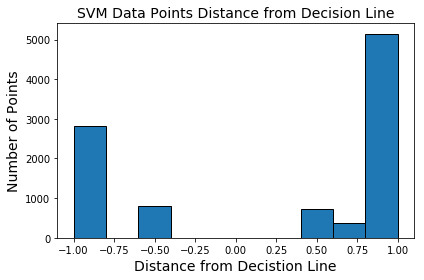

In [31]:
#can look at decision line 
clf.decision_function(xtest)

#plot the histogram of distance from boundry
plt.hist(clf.decision_function(xtest),edgecolor='k')
#add labels and title
plt.xlabel("Distance from Decistion Line", {'fontsize': 14})
plt.ylabel("Number of Points", {'fontsize': 14})

plt.title("SVM Data Points Distance from Decision Line", {'fontsize': 14})
#save figure for papers
plt.tight_layout()
plt.savefig('svm_distance.png')
#show figure in notebook
plt.show()

   classification report, which lists recovery statistics label by label
   
   # I should tune parametes here. Definitely overfitting
   
   SVM does not have predict_proba module. We can instead plot the distance from the decision line.
   Can plot a histogram od the decision function. Need to work on making plot of the decision function on the plane. 
   See if I can plot the support vectors as well.


In [32]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [33]:
#look at confusion matrix
confusion_matrix( ytest , preds_svm )

array([[1252, 2850],
       [2382, 3391]])

## Now look at model measurements: ROC Curve, Precision-Recall Curves and AUC 

In [34]:
clf.decision_function(xtrain)

array([-0.9998721 ,  0.99974384,  0.99600475, ...,  0.9931434 ,
        0.97491131,  0.99501227])

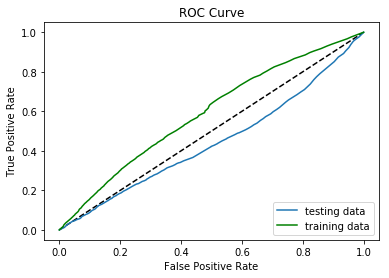

In [35]:

#get false positive rate, true positive rate, and thresholds for training data
xfpr , xtpr , xthres = roc_curve(ytrain , clf.decision_function(xtrain) )

#get false positive rate, true positive rate, and thresholds for test data
fpr , tpr , thres = roc_curve( ytest , clf.decision_function(xtest))

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test
plt.plot(fpr,tpr,label='testing data')
plt.plot(xfpr,xtpr, 'g-',label='training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()

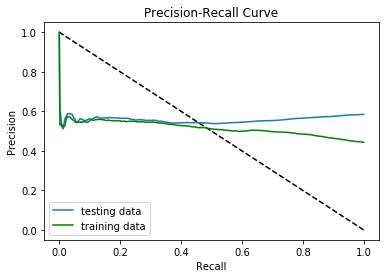

In [36]:
xprec_score,xrecall_score,xthresholds=precision_recall_curve( ytrain , clf.decision_function(xtrain) )

prec_score,recall_score,thresholds=precision_recall_curve( ytest , clf.decision_function(xtest))

plt.plot([1,0],[0,1],'k--')
plt.plot(recall_score,prec_score,label='testing data')
plt.plot(xrecall_score,xprec_score,'g-',label='training data')
#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision-Recall Curve')
plt.legend(loc=3)
plt.show()

In [37]:
roc_auc_score(ytest , clf.decision_function(xtest))

0.44553112671734779

In [38]:
% time cv_auc_scores=cross_val_score(clf, xtrain , ytrain, cv=5, scoring='roc_auc')
print(cv_auc_scores)

CPU times: user 50.7 s, sys: 392 ms, total: 51.1 s
Wall time: 51.2 s
[ 0.5705412   0.59891916  0.58186975  0.53947173  0.56701521]


## The above was with default settings lets tune the model and see if we can imporve.

In [39]:
#know lets tune the parameters for the svm 
from sklearn.model_selection import StratifiedShuffleSplit

# Sklearn recommends for an initial search, a logarithmic grid with basis 10 is often helpful. Using a basis 
# of 2, a finer tuning can be achieved but at a much higher cost.

C_range = np.logspace (-2, 2, 5)
gamma_range = np.logspace(-2, 2, 5)
#param_grid = dict(gamma=gamma_range, C=C_range)

#set parameters for svm {C is smoothness (freedom to fit beyond boundry) ; gamma is the inverse of the radius of influence })
parameters = {'C': C_range , 'gamma' : gamma_range }

#returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

clf=svm.SVC(kernel='rbf', class_weight="balanced"  )        

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs = RandomizedSearchCV(clf,  param_distributions= parameters ,cv=cv, refit= True, n_jobs= 2, random_state= 42, scoring='f1')

#fit grid search on random forest and measure time to complete
%time rs.fit( xtrain ,  ytrain )

CPU times: user 15.4 s, sys: 290 ms, total: 15.7 s
Wall time: 12min 9s


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
          error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02]), 'gamma': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02])},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [40]:
#save best parameters to use on test set
best_c = rs.best_params_['C'] 
best_gamma=rs.best_params_['gamma'] 

#print best parameter results
print("the best regulization C is {} and the best gamma, radius of influence of support vectors is {}".format(best_c,best_gamma))
print("the best f1 score with these is {}".format(rs.best_score_))

the best regulization C is 0.01 and the best gamma, radius of influence of support vectors is 0.01
the best f1 score with these is 0.614035087719


Note that the C value is at the edge of our range. Lets look at the learning curve to we should continue to look for a better C. We will also check the learning curve on the gamma. 

/Users/luca/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/luca/anaconda2/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
/Users/luca/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda2/lib/python2.7/site-packag

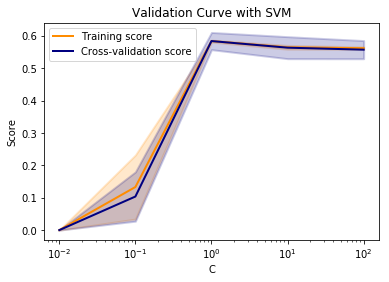

In [41]:
from sklearn.learning_curve import validation_curve
#degree = np.arange(0, 21)
param_range=C_range
train_scores, test_scores = validation_curve( clf , xtrain, ytrain, param_name="C", param_range= param_range , cv=10, scoring="f1", n_jobs=2 )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("C")
plt.ylabel("Score")
#plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

We see that after C gets above 100 the computational time is not benefiting the score. Hence we will move the upper range to 100 and the lower bound to 10^-1.

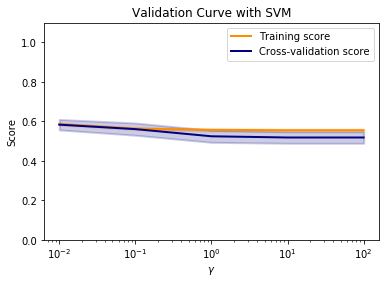

In [42]:
from sklearn.learning_curve import validation_curve
#degree = np.arange(0, 21)
param_range=gamma_range
train_scores, test_scores = validation_curve( clf , xtrain, ytrain, param_name="gamma", param_range= gamma_range , cv=10, scoring="f1", n_jobs=2 )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Looking at the gamma learning curve we begin to overfit at around 10^-3 and no improvement for gamma  below 10^-5. Lets retune with these ranges. 

In [43]:
#know lets tune the parameters for the svm 
from sklearn.model_selection import StratifiedShuffleSplit

# Sklearn recommends for an initial search, a logarithmic grid with basis 10 is often helpful. Using a basis 
# of 2, a finer tuning can be achieved but at a much higher cost.

C_range = np.logspace (-2, 0, 8)
gamma_range = ['auto',best_gamma]
#param_grid = dict(gamma=gamma_range, C=C_range)

#set parameters for svm {C is smoothness (freedom to fit beyond boundry) ; gamma is the inverse of the radius of influence })
parameters = {'C': C_range, 'gamma' : gamma_range }

#returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

clf=svm.SVC(kernel='rbf', class_weight="balanced" ,gamma= best_gamma  )          

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
#rs = GridSearchCV(clf,  param_grid = parameters ,cv=cv, refit= True, n_jobs= 2,  scoring='f1')
rs = RandomizedSearchCV(clf,  param_distributions= parameters ,cv=cv, refit= True, n_jobs= 2, random_state= 42, scoring='f1')
#fit grid search on random forest and measure time to complete
%time rs.fit( xtrain ,  ytrain )

CPU times: user 12.4 s, sys: 275 ms, total: 12.7 s
Wall time: 7min 29s


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
          error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'C': array([ 0.01   ,  0.01931,  0.03728,  0.07197,  0.13895,  0.26827,
        0.51795,  1.     ]), 'gamma': ['auto', 0.01]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [44]:
#save best parameters to use on test set
best_c = rs.best_params_['C'] 
#best_gamma=rs.best_params_['gamma'] 

#print best parameter results
print("the best regulization C is {} and the best gamma, radius of influence of support vectors is {}".format(best_c,best_gamma))
print("the best f1 score with these is {}".format(rs.best_score_))

the best regulization C is 0.138949549437 and the best gamma, radius of influence of support vectors is 0.01
the best f1 score with these is 0.614730891348


In [45]:
#to tune parameters 
clf_svm=svm.SVC( kernel='rbf', C= best_c , gamma= best_gamma , class_weight="balanced")

#fit classifier to validation set
%time clf_svm.fit( xtrain , ytrain )

#get the prediction set for the validation 
preds_train_svm = clf_svm.predict( xtrain )

#make some predictions
preds_svm = clf_svm.predict( xtest )


#print the accuracy score for the training data
training_accuracy = clf_svm.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf_svm.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_svm )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore_train_svm = metrics.f1_score( ytest , preds_svm , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore_train_svm ) )

print (classification_report( ytest , preds_svm ))

CPU times: user 11.5 s, sys: 77.9 ms, total: 11.5 s
Wall time: 11.5 s
Accuracy on training data: 0.57
Accuracy on test data: 0.47
F1 Score on train data: 0.5137
F1 Score on validation (train-test set) data: 0.4798
             precision    recall  f1-score   support

          0       0.40      0.54      0.46      4102
          1       0.56      0.42      0.48      5773

avg / total       0.49      0.47      0.47      9875



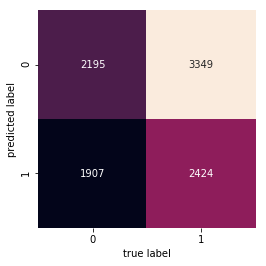

In [46]:

mat = confusion_matrix( ytest , preds_svm  )
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [47]:
confusion_matrix( ytest , preds_svm  )

array([[2195, 1907],
       [3349, 2424]])

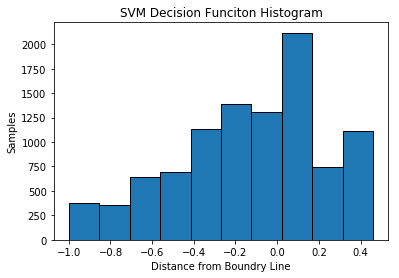

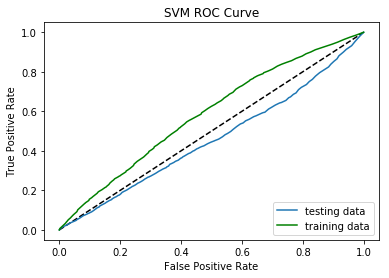

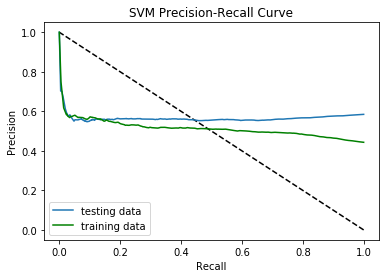

The Area Under the Curve foe the Support Vector Machine is 0.46


In [48]:
#can look at decision line 
clf_svm.decision_function(xtest)

#plot the histogram of distance from boundry
plt.hist(clf_svm.decision_function(xtest),edgecolor='k' )
#add labels
plt.xlabel("Distance from Boundry Line")
plt.ylabel("Samples")
plt.title('SVM Decision Funciton Histogram')
plt.legend(loc=3)
plt.show()


#plot ROC curve 
#get false positive rate, true positive rate, and thresholds for training data
xfpr_svm , xtpr_svm , xthres_svm = roc_curve(ytrain , clf_svm.decision_function(xtrain) )

#get false positive rate, true positive rate, and thresholds for test data
fpr_svm , tpr_svm , thres_svm = roc_curve( ytest , clf_svm.decision_function(xtest) )

#plot base line at .5 probability
plt.plot( [0,1] , [0,1] , 'k--' )
#plot model train and test
plt.plot( fpr_svm , tpr_svm , label= 'testing data')
plt.plot( xfpr_svm , xtpr_svm , 'g-', label= 'training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('SVM ROC Curve')
plt.legend(loc=4)
plt.show()

#plot the precision-recall curve for tuned model
#get values for training set
xprec_score_svm , xrecall_score_svm ,xthresholds_svm =precision_recall_curve( ytrain , clf_svm.decision_function(xtrain) )
#get values for test set
prec_score_svm , recall_score_svm , thresholds_svm = precision_recall_curve( ytest , clf_svm.decision_function(xtest))

#plot lines
plt.plot( [1,0] , [0,1] , 'k--' )
plt.plot( recall_score_svm , prec_score_svm , label= 'testing data')
plt.plot( xrecall_score_svm , xprec_score_svm , 'g-' , label= 'training data')
#add labels
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('SVM Precision-Recall Curve')
plt.legend(loc=3)
plt.show()
         
svm_test_auc=roc_auc_score(ytest , clf_svm.decision_function(xtest))  
print("The Area Under the Curve foe the Support Vector Machine is {:.2f}".format(svm_test_auc))

We see, looking closer at the histogram, the distance each point lays from the separator. Most points are near the boundry indictating that reorders and non-reorders look very similiar. This is an indication that we might need to look for more features to differentiate the classes. In an apple an orange example, we could be only looking at the roundness of the fruit instead of the color. We would hope to find some feature that separates the classes a bit better than this.  

## Improvements to make later: add one hot encode to hod column, scale/normalize all features, cross validate the auc scores, plot decision boundry on plane, add feature engineering...

# Next Random Forest 

Straight out of the box with the default settings. 

# ########################################

In [49]:
#create classifier from best parameters out of grid search
clf_rf=RandomForestClassifier(class_weight="balanced")
#fit classifier to validation set
clf_rf.fit(xtrain,ytrain)

#get the prediction set for the validation 
preds_train_rf = clf_rf.predict(xtrain)

#make some predictions
preds_rf = clf_rf.predict(xtest)


#print the accuracy score for the training data
training_accuracy = clf_rf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf_rf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_rf )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_rf , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}\n".format( fscore ) )


print ( classification_report ( ytest , preds_rf ))

Accuracy on training data: 0.58
Accuracy on test data: 0.46
F1 Score on train data: 0.5462
F1 Score on validation (train-test set) data: 0.4838

             precision    recall  f1-score   support

          0       0.38      0.48      0.43      4102
          1       0.54      0.44      0.48      5773

avg / total       0.48      0.46      0.46      9875



In [50]:
#look at confusion matrix
confusion_matrix( ytest , preds_rf )

array([[1987, 2115],
       [3256, 2517]])

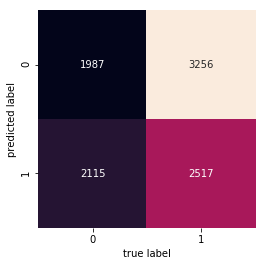

In [51]:

mat = confusion_matrix( ytest , preds_rf )
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Not good looks like we are overfitting again. Once more we will look at tuning the parameters. First through lets finish the analysis here in order to have something to compare the next tuning against.

In [52]:
#Capture model feature importance 
importances=clf_rf.feature_importances_

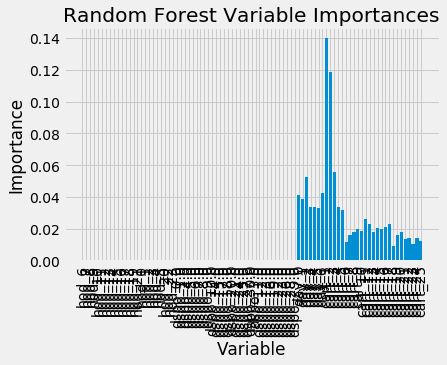

In [53]:
#plot the variable importances
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Random Forest Variable Importances');

#save figure
plt.savefig('feature_importance.png')
#show figure in notebook
plt.show()

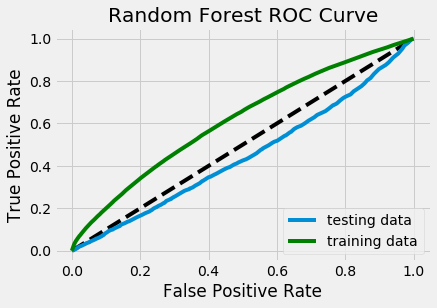

In [54]:
#predict the probabilities for each observation in training set
pred_train_prob_rf = clf_rf.predict_proba(xtrain)[:,1]

#predict the probabilities for each observation in test set
pred_prob_rf = clf_rf.predict_proba(xtest)[:,1]

#get false positive rate, true positive rate, and thresholds for training data
xfpr_rf , xtpr_rf , xthres_rf = roc_curve(ytrain , pred_train_prob_rf )

#get false positive rate, true positive rate, and thresholds for test data
fpr_rf , tpr_rf , thres_rf = roc_curve( ytest , pred_prob_rf )

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test
plt.plot( fpr_rf , tpr_rf ,label='testing data')
plt.plot( xfpr_rf , xtpr_rf , 'g-',label='training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Random Forest ROC Curve')
plt.legend(loc=4)
plt.show()

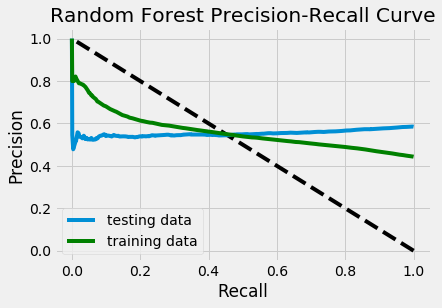

In [55]:

xprec_score_rf , xrecall_score_rf ,xthresholds_rf = precision_recall_curve( ytrain , pred_train_prob_rf )

prec_score_rf , recall_score_rf ,thresholds_rf = precision_recall_curve( ytest , pred_prob_rf)

plt.plot([1,0],[0,1],'k--')
plt.plot( recall_score_rf , prec_score_rf ,label='testing data')
plt.plot( xrecall_score_rf , xprec_score_rf ,'g-',label='training data')

#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Random Forest Precision-Recall Curve')
plt.legend(loc=3)
plt.show()

In [56]:
rf_test_auc=roc_auc_score(ytest , pred_prob_rf)
print("The Area Under the Curve foe the Randam Forest is {:.2f}".format(rf_test_auc))

The Area Under the Curve foe the Randam Forest is 0.45


In [57]:
# cross validate on scoring of auc (20 min to run) 
cv_auc_scores=cross_val_score(clf_rf, xtrain , ytrain , cv=5, scoring='roc_auc')
print(cv_auc_scores)

[ 0.56139944  0.58101339  0.56861406  0.54235851  0.57358638]


# The tuning for the Random Forest parameters

We are overfitting. So lets limit how much the model gets to split down the tree. We do this with max_depth. It should prevent us from fitting to every data point. We will also look at limiting the number of samples to be considered a leaf node. We overfit if each data point is a leaf. 

In [58]:
#know lets tune the parameters for the random forest

#set parametets to tune in Random Grid Search (# depth of trees and # min samples per leaf)
parameters={'max_depth':xrange(1,14),'min_samples_leaf':[5,10,20,30,40,50,100]}

#create an instance of the random forest classifier
rf=RandomForestClassifier(class_weight= "balanced")

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs = RandomizedSearchCV(rf, param_distributions=parameters,cv=5,refit=True,n_jobs=2,random_state=42,scoring='f1')

#fit grid search on random forest over grid
%time rs.fit( xtrain ,  ytrain )

CPU times: user 385 ms, sys: 72.3 ms, total: 457 ms
Wall time: 1.76 s


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'max_depth': xrange(1, 14), 'min_samples_leaf': [5, 10, 20, 30, 40, 50, 100]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [59]:
#save best parameters to use on test set
best_depth = rs.best_params_['max_depth'] 
best_leaf=rs.best_params_['min_samples_leaf'] 

#print best parameter results
print("the best depth of trees is {} with a minimum number of samples per leaf of {}".format( best_depth , best_leaf ))
print("the best f1 score with these is {}".format(rs.best_score_))

the best depth of trees is 4 with a minimum number of samples per leaf of 10
the best f1 score with these is 0.57447926736


# The learning curve for the Random Forest parameters

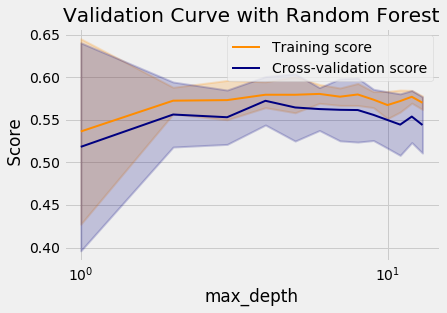

In [60]:
#save the range for the Random Forest n_estimators parameter to a variable
param_range= parameters["max_depth"]
#get learning scores
train_scores, test_scores = validation_curve( clf_rf, xtrain, ytrain, param_name="max_depth", param_range= param_range , cv=10, scoring="f1", n_jobs=2 )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest")
plt.xlabel("max_depth")
plt.ylabel(" Score")
#plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

The learning highlights that the max_depth cross_validation score stabilizes at around 5. We see that going deeper starts to overfit to the training data as the yellow line departs form the purple. 

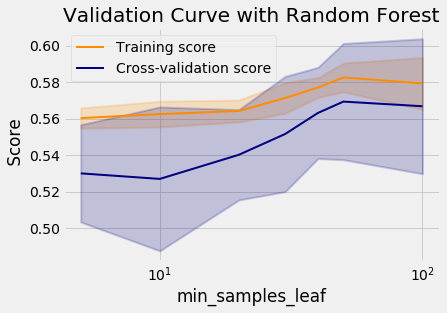

In [61]:
#save the range for the Random Forest n_estimators parameter to a variable
param_range= parameters['min_samples_leaf']
#get learning scores
train_scores, test_scores = validation_curve( clf_rf, xtrain, ytrain, param_name='min_samples_leaf', param_range= param_range , cv=10, scoring="f1", n_jobs=2 )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest")
plt.xlabel('min_samples_leaf')
plt.ylabel(" Score")

lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

As we would expect the more samples in the leaf the less overfit our model is. However, after around 20 we see that start to affect the cross-validation score begins to decrease with the training score. 

In [62]:
#create classifier from best parameters out of grid search
clf_rf=rs.best_estimator_
#fit classifier to validation set
clf_rf.fit(xtrain,ytrain)

#get the prediction set for the validation 
preds_train_rf = clf_rf.predict(xtrain)

#make some predictions
preds_rf = clf_rf.predict(xtest)


#print the accuracy score for the training data
training_accuracy = clf_rf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf_rf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_rf )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_rf , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )


print ( classification_report ( ytest , preds_rf ))

Accuracy on training data: 0.56
Accuracy on test data: 0.47
F1 Score on train data: 0.5555
F1 Score on validation (train-test set) data: 0.5298
             precision    recall  f1-score   support

          0       0.38      0.43      0.40      4102
          1       0.55      0.51      0.53      5773

avg / total       0.48      0.47      0.48      9875



In [63]:
#look at confusion matrix
confusion_matrix( ytest , preds_rf )

array([[1745, 2357],
       [2843, 2930]])

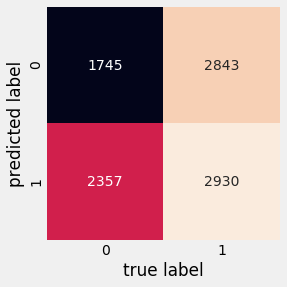

In [64]:
mat = confusion_matrix( ytest , preds_rf )
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Better, we have reduce some of the overfit. Tuning two more parameters we will see if we can do better. Thins time we tune number of trees in the forest and the number of features each tree looks at. We leave the best depth and best min_samples_leaf.  

In [65]:
#know lets tune the parameters for the random forest

#set parametets to tune in Random Grid Search (# trees in forest and # of features per tree)
parameters={'n_estimators':range(1,40),'max_features':['auto',1,2,3,4,5], 'max_depth': [ rs.best_params_['max_depth'] ] , 'min_samples_leaf' : [rs.best_params_['min_samples_leaf'] ] }

#create an instance of the random forest classifier
rf=RandomForestClassifier(class_weight='balanced')

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs = RandomizedSearchCV(rf, param_distributions=parameters,cv=5,refit=True,n_jobs=2,random_state=42,scoring='f1')

#fit grid search on random forest over grid
%time rs.fit( xtrain ,  ytrain )

CPU times: user 517 ms, sys: 88.4 ms, total: 606 ms
Wall time: 2.5 s


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 'max_features': ['auto', 1, 2, 3, 4, 5], 'max_depth': [4], 'min_samples_leaf': [10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [66]:
#save best parameters to use on test set
best_n = rs.best_params_['n_estimators'] 
best_features=rs.best_params_['max_features'] 

#print best parameter results
print("the best number of trees is {} with a maximum number of features of {}".format(best_n,best_features))
print("the best f1 score with these is {}".format(rs.best_score_))

the best number of trees is 16 with a maximum number of features of auto
the best f1 score with these is 0.547139652824


In [67]:
rs.best_params_

{'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'n_estimators': 16}

In [68]:
#create classifier from best parameters out of grid search
clf_rf=rs.best_estimator_
#fit classifier to validation set
clf_rf.fit(xtrain,ytrain)

#get the prediction set for the validation 
preds_train_rf = clf_rf.predict(xtrain)

#make some predictions
preds_rf = clf_rf.predict(xtest)


#print the accuracy score for the training data
training_accuracy = clf_rf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf_rf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_rf )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore_train_rf = metrics.f1_score( ytest , preds_rf , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore_train_rf ) )


print ( classification_report ( ytest , preds_rf ))

Accuracy on training data: 0.54
Accuracy on test data: 0.49
F1 Score on train data: 0.5930
F1 Score on validation (train-test set) data: 0.5894
             precision    recall  f1-score   support

          0       0.35      0.28      0.31      4102
          1       0.55      0.63      0.59      5773

avg / total       0.47      0.49      0.47      9875



We did not achieve much improvement. The validation f1 score, our metric, did improve slightly. In the future we could try tuning these parameters more to improve.

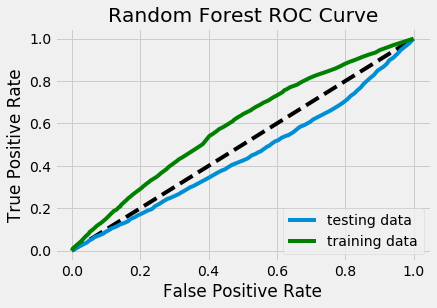

In [69]:
#predict the probabilities for each observation in training set
pred_train_prob_rf = clf_rf.predict_proba(xtrain)[:,1]

#predict the probabilities for each observation in test set
pred_prob_rf = clf_rf.predict_proba(xtest)[:,1]

#get false positive rate, true positive rate, and thresholds for training data
xfpr_rf , xtpr_rf , xthres_rf = roc_curve(ytrain , pred_train_prob_rf )

#get false positive rate, true positive rate, and thresholds for test data
fpr_rf , tpr_rf , thres_rf = roc_curve( ytest , pred_prob_rf )

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test
plt.plot( fpr_rf , tpr_rf ,label='testing data')
plt.plot( xfpr_rf , xtpr_rf , 'g-',label='training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Random Forest ROC Curve')
plt.legend(loc=4)
plt.show()

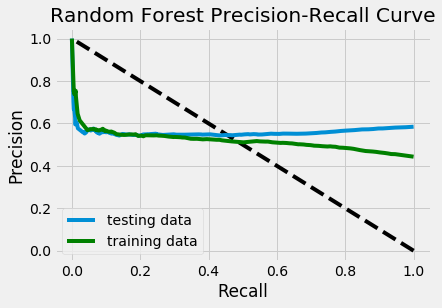

In [70]:

xprec_score_rf , xrecall_score_rf ,xthresholds_rf = precision_recall_curve( ytrain , pred_train_prob_rf )

prec_score_rf , recall_score_rf ,thresholds_rf = precision_recall_curve( ytest , pred_prob_rf)

plt.plot([1,0],[0,1],'k--')
plt.plot( recall_score_rf , prec_score_rf ,label='testing data')
plt.plot( xrecall_score_rf , xprec_score_rf ,'g-',label='training data')

#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Random Forest Precision-Recall Curve')
plt.legend(loc=3)
plt.show()

In [71]:
rf_test_auc=roc_auc_score(ytest , pred_prob_rf)
print("The Area Under the Curve foe the Randam Forest is {:.2f}".format(rf_test_auc))

The Area Under the Curve foe the Randam Forest is 0.45


In [72]:
# cross validate on scoring of auc (20 min to run) 
cv_auc_scores=cross_val_score(clf_rf, xtrain , ytrain , cv=5, scoring='roc_auc')
print(cv_auc_scores)

[ 0.57789176  0.59026411  0.57699051  0.53661095  0.57482595]


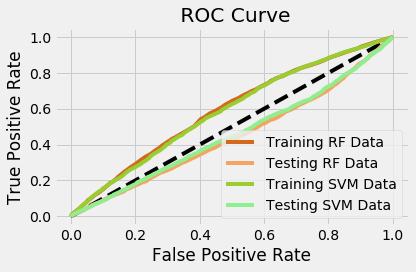

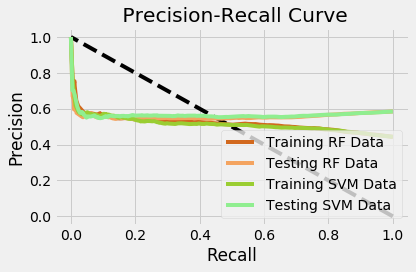

In [73]:
#Plot both models together

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test for each model
plt.plot(xfpr_rf , xtpr_rf , c='chocolate', label='Training RF Data')
plt.plot(fpr_rf , tpr_rf , c='sandybrown', label='Testing RF Data')
plt.plot(xfpr_svm , xtpr_svm , c='yellowgreen' , label='Training SVM Data')
plt.plot(fpr_svm , tpr_svm ,c='lightgreen' , label='Testing SVM Data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(' ROC Curve')
plt.legend(loc=4)
#save figure for papers
plt.tight_layout()
plt.savefig('models_roc.png')
#show figure in notebook
plt.show()

#plot both Precision_Recall models on one
plt.plot([1,0],[0,1],'k--')
plt.plot(xrecall_score_rf , xprec_score_rf, c='chocolate',label='Training RF Data')
plt.plot(recall_score_rf , prec_score_rf,  c='sandybrown' ,label='Testing RF Data')

plt.plot( xrecall_score_svm , xprec_score_svm , c='yellowgreen' , label= 'Training SVM Data')
plt.plot( recall_score_svm , prec_score_svm , c='lightgreen', label= 'Testing SVM Data')

#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(' Precision-Recall Curve')
plt.legend(loc=4)
#save figure for papers
plt.tight_layout()
plt.savefig('models_PR-curve.png')
#show figure in notebook
plt.show()

# Lets add in one more model--Single Vector Decomposition

At this point you will need to run the notebook SVD in the parent folder. Once ran, come back here and finish this notebook. 

In [74]:
%store -r svd_predicted
svd_predicted.head()

,user_id,product_id,product_name,Prediction,ypred,order_id
2674,102,8174,NaN,0.000000,0.0,2531610
2681,102,13629,NaN,0.000000,0.0,2531610
2675,102,21137,NaN,0.000000,0.0,2531610
2680,102,23645,NaN,0.000000,0.0,2531610
0,102,24852,Banana,0.065486,1.0,2531610


In [75]:
ypred_svd = np.array(svd_predicted['ypred'])

In [76]:
svd_predicted['Prediction'] = svd_predicted['Prediction'].fillna(0)

In [77]:
svd_predicted.head()

,user_id,product_id,product_name,Prediction,ypred,order_id
2674,102,8174,NaN,0.000000,0.0,2531610
2681,102,13629,NaN,0.000000,0.0,2531610
2675,102,21137,NaN,0.000000,0.0,2531610
2680,102,23645,NaN,0.000000,0.0,2531610
0,102,24852,Banana,0.065486,1.0,2531610


In [78]:
preds_svd=svd_predicted['Prediction'].astype(float).values
preds_svd

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [79]:
#read in svd trainging predicted labels
%store -r tng_predicted
tng_predicted.head(15)

,user_id,product_id,reordered,product_name,Prediction,ypred,order_id
0,102,4920,1,Seedless Red Grapes,0.006003,1.0,2196914
1,102,9839,1,Organic Broccoli,0.005151,1.0,2196914
2,102,15290,1,Orange Bell Pepper,0.009581,1.0,2196914
3,102,19051,1,"Pita Chips, Simply Naked, Party Size",0.000863,0.0,2196914
4,102,23645,0,NaN,0.000000,0.0,2196914
5,102,23794,0,NaN,0.000000,0.0,2196914
6,102,24852,1,Banana,0.046542,1.0,2196914
7,102,28985,1,Michigan Organic Kale,0.003868,1.0,2196914
8,102,30720,1,Sugar Snap Peas,0.001892,0.0,2196914
9,102,31487,0,NaN,0.000000,0.0,2196914


In [80]:
#fill in zeros for missing NaN in Prediction value columns
tng_predicted['Prediction'] = tng_predicted['Prediction'].fillna(0)

In [81]:
#convert prediction column values to float
preds_svd_tng=tng_predicted['Prediction'].astype(float).values
preds_svd_tng

array([ 0.00600305,  0.00515061,  0.00958084, ...,  0.0018753 ,
        0.00172809,  0.0018753 ])

In [82]:
preds_svd

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [83]:
svd_predicted['ypred'].astype(int).values

array([0, 0, 0, ..., 0, 0, 0])

In [84]:
preds_train_svm

array([0, 1, 1, ..., 0, 0, 0])

In [85]:
tng_predicted['ypred'].astype(int).values

array([1, 1, 1, ..., 0, 0, 0])

In [86]:
preds_svm

array([1, 1, 1, ..., 1, 1, 0])

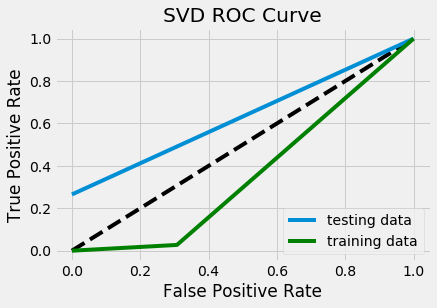

In [87]:

#get false positive rate, true positive rate, and thresholds for training data
xfpr_svd , xtpr_svd , xthres_svd  = roc_curve(ytrain , tng_predicted['ypred'].astype(int).values)

#get false positive rate, true positive rate, and thresholds for test data
fpr_svd , tpr_svd , thres_svd = roc_curve(ytest , svd_predicted['ypred'].astype(int).values)

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test
plt.plot( fpr_svd , tpr_svd ,label='testing data')
plt.plot( xfpr_svd , xtpr_svd , 'g-',label='training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('SVD ROC Curve')
plt.legend(loc=4)
plt.show()

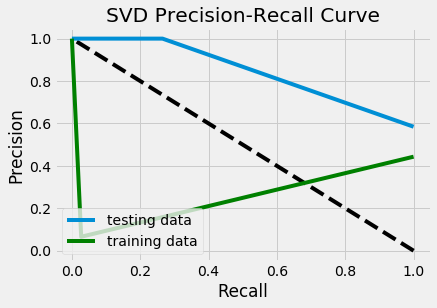

In [88]:
xprec_score_svd , xrecall_score_svd ,xthresholds_svd = precision_recall_curve( ytrain , tng_predicted['ypred'].astype(int).values )

prec_score_svd , recall_score_svd ,thresholds_svd = precision_recall_curve(ytest , svd_predicted['ypred'].astype(int).values)

plt.plot([1,0],[0,1],'k--')
plt.plot( recall_score_svd , prec_score_svd ,label='testing data')
plt.plot( xrecall_score_svd , xprec_score_svd ,'g-',label='training data')

#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('SVD Precision-Recall Curve')
plt.legend(loc=3)
plt.show()

In [89]:
svd_test_auc=roc_auc_score( ytest , preds_svd)
print("The Area Under the Curve for the SVD is {:.2f}".format(svd_test_auc))

The Area Under the Curve for the SVD is 0.73


In [90]:
svd_labels= np.array(svd_predicted['ypred'].astype(int))

In [91]:
#print testing f1 score
fscore = metrics.f1_score( ytrain , tng_predicted['ypred'].astype(int).values, pos_label=1,average='binary')
print("F1 Score on train data: {:0.4f}".format( fscore ) )

F1 Score on train data: 0.0385


In [92]:
#print training f1 score
fscore_train_svd = metrics.f1_score( ytest , svd_labels ,average='binary')
print("F1 Score on test data: {:0.4f}".format(fscore_train_svd))

F1 Score on test data: 0.4192


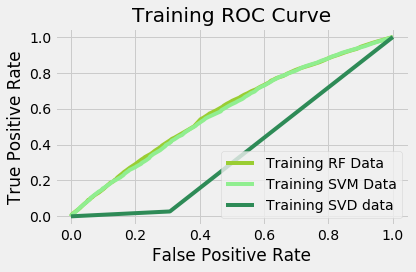

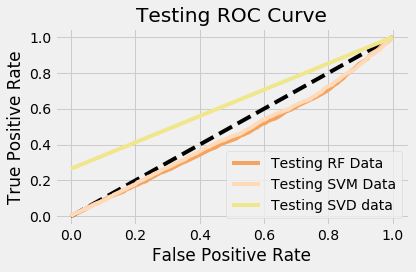

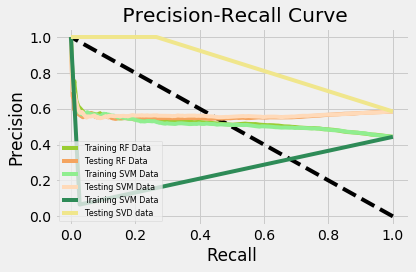

In [93]:
#Plot both models together

plt.plot(xfpr_rf , xtpr_rf , c='yellowgreen', label='Training RF Data')
plt.plot(xfpr_svm , xtpr_svm , c='lightgreen' , label='Training SVM Data')
plt.plot( xfpr_svd , xtpr_svd , c='seagreen' ,label='Training SVD data')


#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Training ROC Curve')
plt.legend(loc=4)
#save figure for papers
plt.tight_layout()
plt.savefig('models_roc.png')
#show figure in notebook
plt.show()


#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test for each model

plt.plot(fpr_rf , tpr_rf , c='sandybrown', label='Testing RF Data')
plt.plot(fpr_svm , tpr_svm , c='peachpuff'  , label='Testing SVM Data')
plt.plot( fpr_svd , tpr_svd , c='khaki', label='Testing SVD data')


#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Testing ROC Curve')
plt.legend(loc=4)
#save figure for papers
plt.tight_layout()
plt.savefig('models_roc.png')
#show figure in notebook
plt.show()




#plot both Precision_Recall models on one
plt.plot([1,0],[0,1],'k--')
plt.plot(xrecall_score_rf , xprec_score_rf , c='yellowgreen', label='Training RF Data')
plt.plot(recall_score_rf , prec_score_rf,  c='sandybrown' ,label='Testing RF Data')

plt.plot( xrecall_score_svm , xprec_score_svm , c='lightgreen' , label= 'Training SVM Data')
plt.plot( recall_score_svm , prec_score_svm , c='peachpuff' , label= 'Testing SVM Data')

plt.plot( xrecall_score_svd , xprec_score_svd , c='seagreen'  , label='Training SVM Data')
plt.plot( recall_score_svd , prec_score_svd , c='khaki', label='Testing SVD data')


#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(' Precision-Recall Curve')
plt.legend(loc= 3, fontsize=8)
#save figure for papers
plt.tight_layout()
plt.savefig('models_PR-curve.png')
#show figure in notebook
plt.show()

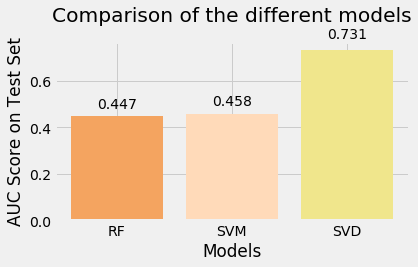

In [94]:
#dictionary to hold auc scores form tuned models
plot_model={'RF':rf_test_auc ,'SVM':svm_test_auc, "SVD" :svd_test_auc}

#make an instance for plotting figures
fig, ax = plt.subplots()

#set parameters for bar chart
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

#plot bar for chart
rects1 = ax.bar(ind, plot_model.values(), color= ['sandybrown','peachpuff','khaki'])

#define a function to add bar chart labels to bars (straight from matplotlib docs)
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*float(height),'%.3f' % float(height),ha='center', va='bottom')
        
#call function to add bar char labels to bars
autolabel(rects1)


# add some text for axes ticks
ax.set_xticks(ind)
ax.set_xticklabels(plot_model.keys())

ax.legend()

#add label and title
plt.title("Comparison of the different models",y = 1.08)
plt.xlabel("Models")
plt.ylabel("AUC Score on Test Set")
#save figure for papers
plt.tight_layout()
plt.savefig('models_auc.png')
#show figure in notebook
plt.show()


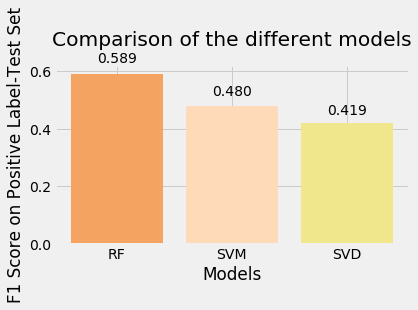

In [95]:
#dictionary to hold auc scores form tuned models
plot_model={'RF':fscore_train_rf ,'SVM':fscore_train_svm, "SVD" :fscore_train_svd}

#make an instance for plotting figures
fig, ax = plt.subplots()

#set parameters for bar chart
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

#plot bar for chart
rects1 = ax.bar(ind, plot_model.values(), color= ['sandybrown','peachpuff','khaki'])

#define a function to add bar chart labels to bars (straight from matplotlib docs)
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*float(height),'%.3f' % float(height),ha='center', va='bottom')
        
#call function to add bar char labels to bars
autolabel(rects1)


# add some text for axes ticks
ax.set_xticks(ind)
ax.set_xticklabels(plot_model.keys())

ax.legend()

#add label and title
plt.title("Comparison of the different models",y = 1.08)
plt.xlabel("Models")
plt.ylabel("F1 Score on Positive Label-Test Set")
#save figure for papers
plt.tight_layout()
plt.savefig('models_f1score.png')
#show figure in notebook
plt.show()

